In [ ]:
'''
4. Text Summarization (Extractive) 
Dataset: CNN/DailyMail or news articles + summaries 
Goal: Build an extractive summarizer using transformer encoder. 
Key tasks: 
 Represent document using transformer encoder 
 Predict which sentences to extract (binary classification per sentence) 
 Train on sentence-level alignment with summaries
'''

In [71]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Model
from nltk.tokenize import sent_tokenize

def safe_sent_tokenize(text):
    return text.split('. ') if '. ' in text else text.split('.\n')

In [72]:
# 1. Load CNN/DailyMail Dataset
data = load_dataset("cnn_dailymail", "3.0.0")
train_data = data['train'].shuffle(seed=42).select(range(300))

In [73]:
# 2. Sentence-level Labeling
all_sents, all_labels = [], []
for article, summary in zip(train_data['article'], train_data['highlights']):
    article_sents = safe_sent_tokenize(article)
    summary_sents = safe_sent_tokenize(summary)
    for sent in article_sents:
        all_sents.append(sent)
        all_labels.append(1 if sent in summary_sents else 0)

In [74]:
# 3. Tokenization and Padding
vocab_size = 5000
max_len = 50

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<UNK>")
tokenizer.fit_on_texts(all_sents)
sequences = tokenizer.texts_to_sequences(all_sents)
padded_inputs = pad_sequences(sequences, maxlen=max_len, padding='post')
labels = np.array(all_labels)

X_train, X_val, y_train, y_val = train_test_split(padded_inputs, labels, test_size=0.2, random_state=42, stratify=labels)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(5000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

In [75]:
# 4. Transformer Encoder Block
def transformer_encoder_block(input_dim, num_heads, ff_dim):
    inputs = layers.Input(shape=(None, input_dim))
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_dim)(inputs, inputs)
    out1 = layers.LayerNormalization()(inputs + attn_output)
    ffn = layers.Dense(ff_dim, activation='relu')(out1)
    ffn_output = layers.Dense(input_dim)(ffn)
    out2 = layers.LayerNormalization()(out1 + ffn_output)
    return Model(inputs, out2)

In [76]:
# 5. Build Model
embedding_dim = 64
num_heads = 2
ff_dim = 64

tf.random.set_seed(42)
inputs = layers.Input(shape=(max_len,), dtype='int32')
x = layers.Embedding(vocab_size, embedding_dim)(inputs)
x = layers.Dropout(0.2)(x)
encoder_block = transformer_encoder_block(embedding_dim, num_heads, ff_dim)
x = encoder_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
model.summary()

# 6. Train Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_7 (Embedding)              │ (None, 50, 64)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_14 (Functional)           │ (None, 50, 64)              │          41,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 361,857 (1.38 MB)

 Trainable params: 361,857 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9712 - loss: 0.0681 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.9996 - val_loss: 0.0040 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9998 - loss: 0.0025 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.9996 - val_loss: 0.0039 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9996 - loss: 0.0041 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.9996 - val_loss: 0.0039 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9996 - loss: 0.0039 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.9996 - val_loss: 0.0039 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accu

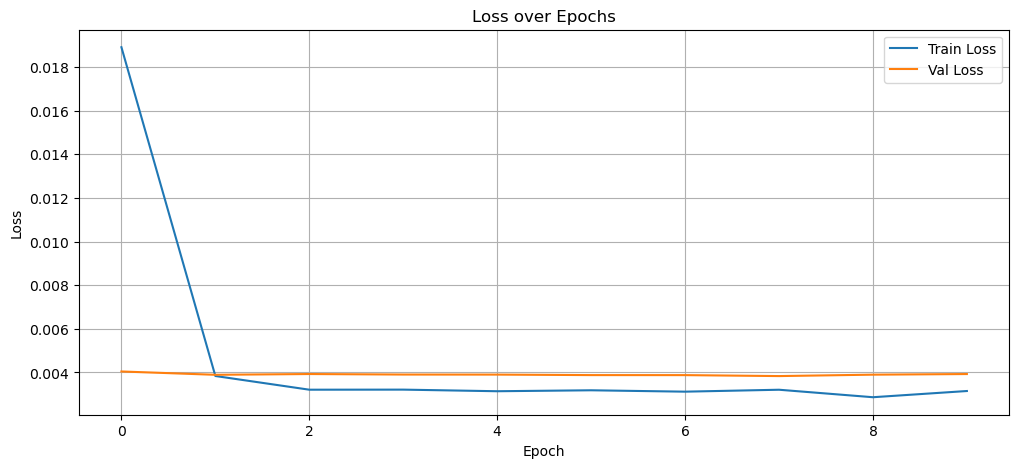

In [77]:
# 7. Visualization
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
# 8. Extractive Summary Generation
def extract_summary(model, tokenizer, article):
    sents = safe_sent_tokenize(article)
    seqs = tokenizer.texts_to_sequences(sents)
    padded = pad_sequences(seqs, maxlen=max_len, padding='post')
    preds = model.predict(padded)[:, 0]
    return " ".join([s for s, p in zip(sents, preds) if p > 0.5])

In [79]:
# 9. Example Summary
test_article = data['test'][0]['article']
predicted_summary = extract_summary(model, tokenizer, test_article)
print("\nPredicted Summary:\n", predicted_summary)
print("\nOriginal Summary:\n", data['test'][0]['highlights'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step

Predicted Summary:
 

Original Summary:
 Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June .
Israel and the United States opposed the move, which could open the door to war crimes investigations against Israelis .
